# Character Recognition using Baesian Classifier and Naive Bayes Classifier
**Contributers:**

**Aditya | Divyansh | Himansu | Sarthak | Tanuja**

Here we are given hand written alphabets and we have to predict the alphabets. We are going to use the Baesian Classifier and Naive Bayes Classifier for the purpose. 

The need for Naive Bayes Classifier is that it is a probabilistic classifier. It is a classifier that can be used to estimate the probability of a sample belonging to a particular class. But as there are large number of features in the data, it is not possible to use the features to calculate the probability. So, comes the need for Naive Bayes Classifier. 

Naive Bayes classifier are surely an approximation of the true probaility, but how good it turns out we will know only after creating the model. Here we will implement everything first using the tools and libraries provided by the python. Later we will do everything from scratch.

We have added necessary markdown and comments to help you understand the code, we have also added dockstrings where ever it felt necessary. We also have extensively used plots and heatmaps to have a better understanding of the data and the results.

**Our code is well optimised and our model from scratch will be almsot as fast as the model from the library. We have done as much vectorised operations as possible. Also to see the plots and interactive figures properly please view the notebook in jupyter enviroment and not as pdf etc.**

## The notebook include the following

### Assignment requirements

- Data Preprocessing
- Data Visualization
- Train Test Split using Scikit Learn
- Data Analysis
- Creating and Training the Model using Scikit-Learn
- Testing the Model using Scikit-Learn
- Train Test Split from scratch

### Extra credit

- Creating and Training a Model from scratch
- Testing the Model from scratch
- Finding accuracy of the Model
- Creating a confusion matrix
- Visualizing the confusion matrix
- Creating a Classification Report

### Experimental
This part of the notebook may take some time to run, around 15 mins, because multiple models are being trained and tested in this part. 
- Trying to improve the model
- Tuning the Hyperparameters
- Finding relation preprocessing threshold and accuracy
- Visualizing threshold vs accuracy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Lets see how the data look like
First we will import the dataset as a pandas dataframe. This helps us to understand the dataset better and manipulate it better. After that we will identify the features and labels and mark the columns based on the features and labels.
We will also like to know the number of images in the dataset.

In [3]:
# import the images as panda dataframe
df = pd.read_csv('A_Z Handwritten Data.csv')
df.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# column 0 is the class label as they range from 0 to 25

# lest find number of pixels in each image
nFeatures = df.iloc[0, 1:].shape[0]
nFeatures

784

In [5]:
# lets label the coluns properly in the dataframe
pixelsNumbers = ['pixel' + str(i) for i in range(nFeatures)]
columns = ['label'] + pixelsNumbers
df.columns = columns
df.head() 

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# store a copy of the dataframe if needed later
df_copy = df.copy()

In [7]:
# lets store the total number of samples
nSamples = df.shape[0]
nSamples

372450

## Visualising the dataset
Before starting to work on any ML model we should have a clear idea of the dataset. We should visualise sample images of the dataset and also the distribution of the labels.

### How images look like
We can create a color map of the images to see how hand writeen images really look like.

28


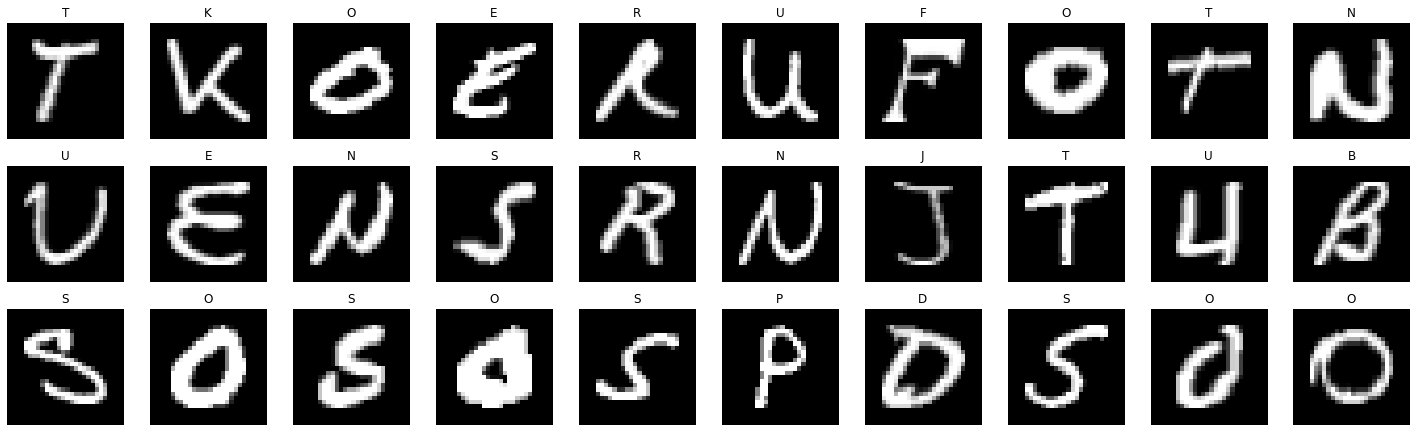

In [8]:
# plotting few images
# we know the fact images are square though this is only needed for the plotting as for the model
# we will use only the features as an array of pixels

# we will plot some sample images using gray scale heatmaps
dim = int(nFeatures ** 0.5)
print(dim)

figure = plt.figure(figsize=(20, 20))
for i in range(30):
    # select random image , will change with each run
    index = np.random.randint(0, nSamples)
    # get the image at the index
    image = df.iloc[index, 1:].values.reshape(dim, dim)
    # plot the image
    plt.subplot(10, 10, i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    # show the label under the image as A-Z instead of 0-25
    label = chr(df.iloc[index, 0] + 65)
    plt.title(label)
plt.tight_layout()
plt.show()


### Distribution of class labels
We must also know the distribution of the labels. Thid will help us check if all labels are balanced or not. If labels are not balanced then we will have to be cautious about out error metrics. Even if we will not use it lets still see the distribution of the labels.

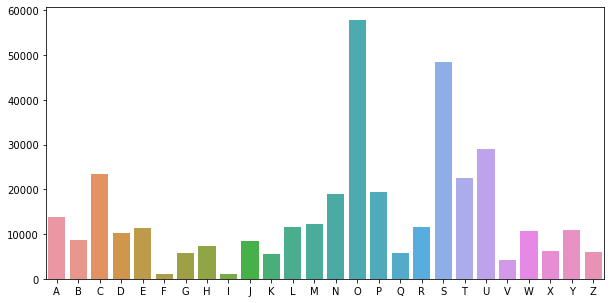

In [9]:
# lets check the distribution of the labels
lCount = df['label'].value_counts()
# lets plot the distribution
plt.figure(figsize=(10, 5))
# convert the index to charaters in the plot to A - Z
lCount.index = [chr(i + 65) for i in lCount.index]
lCount = lCount.sort_index()
sns.barplot(x=lCount.index, y=lCount.values)
plt.show()

So as we can see all labels are not balanced but the difference is not very large, except for F and I. We can think of reasons for this, as why the data collection is not balanced, or it might be the case that this nature is completly random or created intentioanlly. 

This distribution is surely not due to natural frequency of the labels in the english language as in that case letters like Z, X etc should be less frequent rather than F and I. 

For the time being this is not much a problem for us and we will not bother much, except we will later calculate the error for each class indiviaully as well to see if this has any significant impact on the accuracy.

## Data Preprocessing
Now as we can see the features that are pixels have values ranging from 0 to 255. Now as we have to use Bayesian Classifier, we need to convert the values to range from 0 to 1.

Also we need to create a probabilty distribution for each feature so if features have continuous values and we dont know the distribution so we cant create a effective probability distribution. 

So instead of generating a proability disiribution for each feature we can create a probablity mass function for each feature, but for that we will have to convert the features into descrete values.


In [10]:
# normalising the data
# we will normalise the data by dividing each pixel value by 255
# this will make the data values between 0 and 1

# we wont do that here because it will be computatuonal expensive
# and we can move on without doing it as well because we have to anyway descretize the data
# df[pixelsNumbers] = df[pixelsNumbers] / 255


### Discretizing the features
Here the images are basically drawn as white pixels on black background, we can ignore the white intensity and convert the whole image into only two shades complete white or complete black. 

We can chnage every pixel with value more than the half of max value to max and every pixel with value less than the half of max value to 0.

We will also verify if the images remain recognisale to humans or not after this transformation.

In [11]:
# making data descrete
# we will convert every feature to either 0 or 1 as mentioned by the above strategy
# we will use the threshold of 0.5
threshold = 255 / 2  # make it 0.5 if data is normalised i.e when the above cell in uncommented
df[pixelsNumbers] = df[pixelsNumbers].apply(lambda x: (x > threshold).astype(int))
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


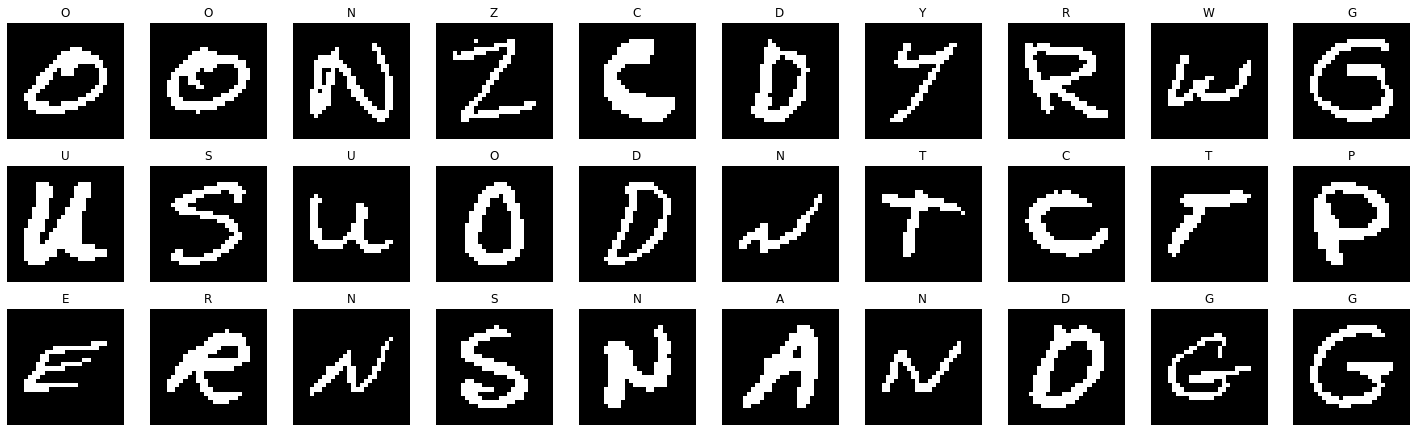

In [12]:
# now lets see how images looks like to humans after descretization
# we will plot the images as we did before
figure = plt.figure(figsize=(20, 20))
for i in range(30):
    # select random image
    index = np.random.randint(0, nSamples)
    image = df.iloc[index, 1:].values.reshape(dim, dim)
    # plot the image
    plt.subplot(10, 10, i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    # show the label under the image in  charaters A-Z instead of 0-25
    label = chr(df.iloc[index, 0] + 65)
    plt.title(label)
plt.tight_layout()
plt.show()

So we can see that images are still recognisable to humans after this transformation, so the amount of information lost for humans are very less. 

### Dividing the data into training and test set
Like any learning model we need to divide the data into training and test set. We will use 80% of the data for training and 20% for testing. We can use other values as well depending on preferences and size of data set available. The split should be random, so we should shuffle the data or atleast the index of the data before splitting. 

In [13]:
# divide the data into train and test
# we will use the inbuilt library function for this
# later we will do everything from scratch as stated earlier
train, test = train_test_split(df, test_size=0.2)
train.shape, test.shape

((297960, 785), (74490, 785))

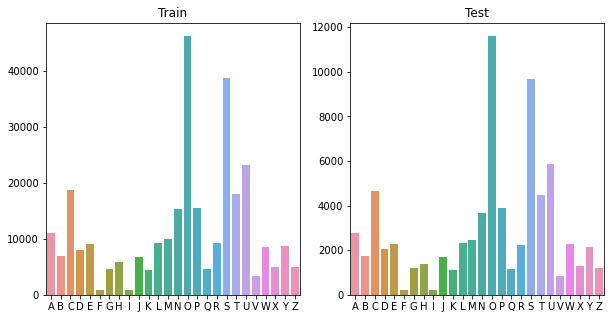

In [14]:

# lets see and plot label distribution in train and test
# this will help us to understand the quality of the partision
trainLabels = train['label'].value_counts()
testLabels = test['label'].value_counts()

# plot both the distributions in subplots
figure = plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Train')
# convert the index to charaters in the plot
trainLabels.index = [chr(i + 65) for i in trainLabels.index]
trainLabels = trainLabels.sort_index()
testLabels.index = [chr(i + 65) for i in testLabels.index]
testLabels = testLabels.sort_index()
sns.barplot(x=trainLabels.index, y=trainLabels.values)
plt.subplot(122)
plt.title('Test')
sns.barplot(x=testLabels.index, y=testLabels.values)
plt.show()

We can see that the distribution partision was random as done by the library, so we do not need to shuffle it.

## Training the model
Now we have divided the data into training and test set, we can train the model. But first we need to understand what is the model and what training the model means.

### Bayesian Classifier
The Bayesian Classifier is a probabilistic classifier. It is a classifier that can be used to estimate the probability of a sample belonging to a particular class. 

### Training a Bayesian Classifier
Training a Bayesian Classifier basically means to know the distribution of the features given a class or a label.

In our case we have features which is the pixel values of the images and labels which is the class of the image. let say them **X**. We also have a label for each image lets call it Y. Each X is of size 784 and each of those 784 values in X can now be 0 or 1.

So here learning the model means learning the probability of each possible or atleast each required value of **X**, given a class or label. i.e.
We need to learn 
\begin{equation}
P(X = [0* 1*]|Y)
\end{equation}
Where [0\* 1\*] means an array of length same as the number of features and each values can be either zero or one .

### Need of Naive Bayes Classifier
So we saw what training a bayes classifier means and how we can train it, so why comes the need of training a naive bayes classifier?

If we stick to the fact that we need the learn probability of each possible value of **X**, given a class or label, then how many probabilities do we need to learn? This will depend on number of possibe values of **X** and number of classes or labels.

Lets see how many possible values of **X** we have to learn for any particular label as here label are only 26 so that will not matter much. So as **X** is of length 784, there are total $2^{784}$ possible values of **X**, this is simply too large and no amount of data we can generate so that we can have enough sample to estimate these probabilities, even the required ones.

Naive Bayes Classifier is an aproximation of calculating that probability. As per Naive Bayes approximation:
\begin{equation}
P(X = someX|Y) = \prod_{i=1}^{784}P(X_i = someX_i|Y)
\end{equation}

So here we assume that all the features are independednt of each other and we can calculate the probability of each feature given a class or label and use it to estimate the probabilty of the whole feature vector.

We used the sikitlearn library to train the model : https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html#sklearn.naive_bayes.CategoricalNB

In [15]:
# lets define the model
# we will use the sklearn library functions for this
import sklearn.naive_bayes as nb

# create and tune the model
model = nb.CategoricalNB(fit_prior=True, min_categories=2)
model.fit(train[pixelsNumbers].values, train['label'].values)

CategoricalNB(min_categories=2)

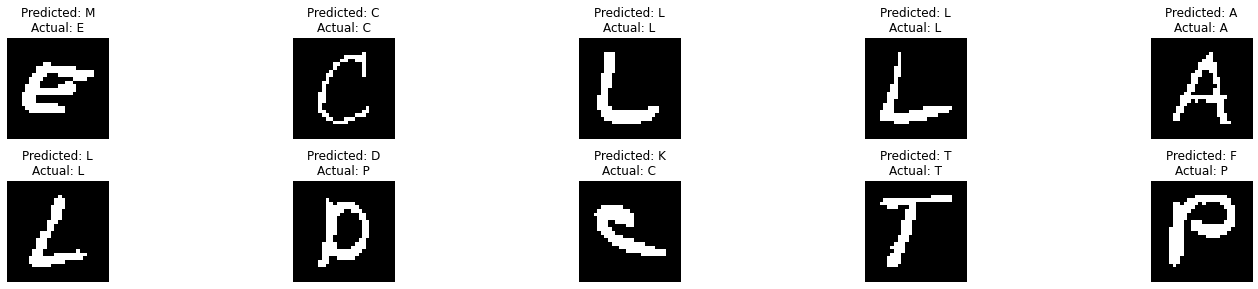

In [16]:
# now the model is trained, lets see how it predicts some of the random images

# we will predict some unseem images from the test data and see the results
# we will also plot the image and the predicted label and actual label
n = 10
figure = plt.figure(figsize=(20, 20))
for i in range(n):
    index = np.random.randint(0, test.shape[0])
    features = test.iloc[index, 1:].values
    label = test.iloc[index, 0]
    image = features.reshape(dim, dim)

    # get the prediction from the model
    prediction = model.predict(features.reshape(1, -1))
    # plot the image as a subplot

    plt.subplot(n, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    # plot the predicted label and actual label
    plt.title('Predicted: ' + chr(prediction[0] + 65) + '\nActual: ' + chr(label + 65))
plt.tight_layout()
plt.show()

## Measuring the performance of the model
Now we have trained the model, we can measure the performance of the model. We will use the accuracy of the model to measure the performance of the model. We have saved our test set for this purpose only.

We will also use the confusion matrix to measure the performance of the model. This is a table that shows the number of correct and incorrect predictions made by the model. 

Later we will also use the classification report to measure the performance of the model. This is a table that shows the precision, recall, f1-score and support for each class. This is more useful when we have more than two classes and the distribution of the classes is not balanced.



### Error rate of the model on whole test set
Error is simiply the fraction of wrong predictions made by the model. This is just the opposite of accuracies.
\begin{equation}
Error = n_{wrong}/n_{total}
\end{equation}
\begin{equation}
Accuracy = 1 - Error = 1 - (n_{wrong}/n_{total}) = n_{correct}/n_{total}
\end{equation}

In [17]:
# calculating the error using the test data and inbuilt function provided on the model class
score = model.score(test[pixelsNumbers], test['label'])
print("Score using Categorical NB: ",score)

Score using Categorical NB:  0.7064975164451605


## Creating a Naive Bayes Classifier from scratch
Now as we have exploited the tools and libraries provided by the python, we can create a Naive Bayes Classifier from scratch. This will give us the better uderstanding of the model and how to train it.

### Partisioning the data into test and train
Previously we used inbuilt functions to split the data into test and train set. But now we will do it from scratch.

In [18]:
# partisioning the data into 80:20 
# this time we will do this ourselves



# first as the data is not suffled either we can suffle it inplace 
# or we can suffle the index and use them to pick the rows

# getting a random premutation of the index
indexes = np.random.permutation(range(0, nSamples))

# taking 80% of the data as train data and rest as test data
trainIndexes = indexes[:int(nSamples * 0.8)]
testIndexes = indexes[int(nSamples * 0.8):]

test = df.iloc[testIndexes, :]
train = df.iloc[trainIndexes, :]

Check again the partisioning of the data into test and train set.

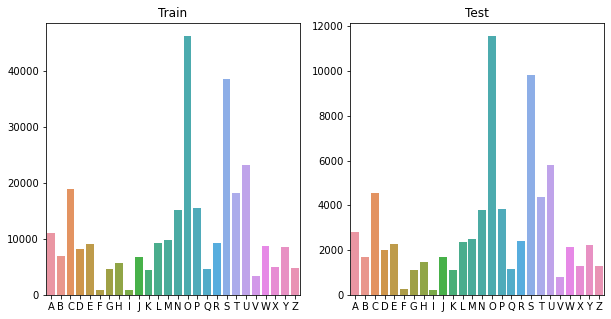

In [19]:
# plotting the distribution of the labels in train and test
# This will help us to understand the quality of the partision
trainLabelsCnt = train['label'].value_counts()
testLabelsCnt = test['label'].value_counts()

#plot the distribution in subplots
figure = plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Train')
# convert the index to charaters in the plot to A - Z
trainLabelsCnt.index = [chr(i + 65) for i in trainLabelsCnt.index]
trainLabelsCnt = trainLabelsCnt.sort_index()
testLabelsCnt.index = [chr(i + 65) for i in testLabelsCnt.index]
testLabelsCnt = testLabelsCnt.sort_index()
sns.barplot(x=trainLabelsCnt.index, y=trainLabelsCnt.values)
plt.subplot(122)
plt.title('Test')
sns.barplot(x=testLabelsCnt.index, y=testLabelsCnt.values)
plt.show()

## Creating a Model from scratch
First we will learn the probability distribution for each pixel feature for all the labels. We will store it as a dictionary indexed by label and an array of probabilities for each pixel feature.

Training the model means learning the probability of each possible value of **X**, given a class or label. We have explained what training means in the previous section.

In [20]:
# creating and training the model


# lets create a function to create the model
def createModel(train):
    # dictionary to store the model
    # model will store two things prior and conditional  probabilities
    model = {'prior' : [], 'conditional' : {}}
    
    
    # we will group the data by label
    # and then calculate the probabilities for each pixel

    for label in train['label'].unique():
        # get the data for the label
        data = train[train['label'] == label]
        # calculate the conditional probabilities for each pixel
        countPixels = data[pixelsNumbers].sum()
        probPixels = (countPixels + 1) / (data.shape[0] + 2)
        # convert the probabilities to basic numpy array
        probPixels = probPixels.values
        model['conditional'] = {**model['conditional'], **{label: probPixels}}

    # sort the model by the label
    model['conditional'] = {k: v for k, v in sorted(model['conditional'].items(), key=lambda item: item[0])}
    
    # lets calculate the prior probabilities

    # get the total number of labels
    nLabels = train['label'].unique().shape[0]
    # calculate the prior probabilities
    prior = train['label'].value_counts() / nSamples
    # convert the probabilities to basic numpy array
    prior = prior.values
    model['prior'] = prior
    return model
       

In [21]:
ourModel = createModel(train)
print(ourModel.keys())

dict_keys(['prior', 'conditional'])


### Visualising the trained model
Now we have learned the probability distribution for each pixel feature for all the labels. We can see the distribution of the features for each label. We can better visualise it by creating a heat map for each label. We will create gray scale map to see if letters are still visible.

**As the values are binary we are basically storing the probability a pixel is white or 1**, the prbability a pixel is black or 0 will be 1 - probability of pixel being white. So we can plot this by just creating a heatmaps of the probabilities that a pixel should be white or black.

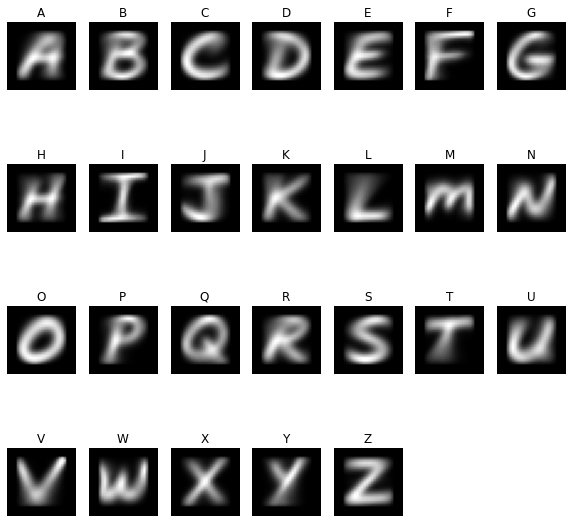

In [22]:
# lets crate heat map of the model for each label

# create figure to plot 26 subplots for A to Z
figure = plt.figure(figsize=(10, 10))
for label in ourModel['conditional'].keys():
    # get the probabilities for the label
    probPixels = ourModel['conditional'][label]
    # plot the heat map
    plt.subplot(4, 7, label + 1)
    plt.title(chr(label + 65))
    plt.imshow(probPixels.reshape(dim, dim), cmap='gray')
    plt.axis('off')
plt.show()

Note that the above plot is not plot of the pixel values but the probabilities learned by the model for each pixel given a label. So we can see that the model is sucessfully learning the probability of each pixel given a label.   

As the values are binary we are basically storing the probability a pixel is white or 1 as stated above, and thats whu plotting it has been possible.

We can also see the values of these probabilities for each label, butwe are plotting only one as that will be similar for all the labels, and we already have an idea from the above images.

We should also note that it is only due to mere nature of the data, i.t it being image and features being binary pixel values that we can see the conditional probability for each features given a label similar to the image of the label. This would not be case in most of the cases.

But in this case we can imagine it as the average color of each pixel for a particular label.

<AxesSubplot:>

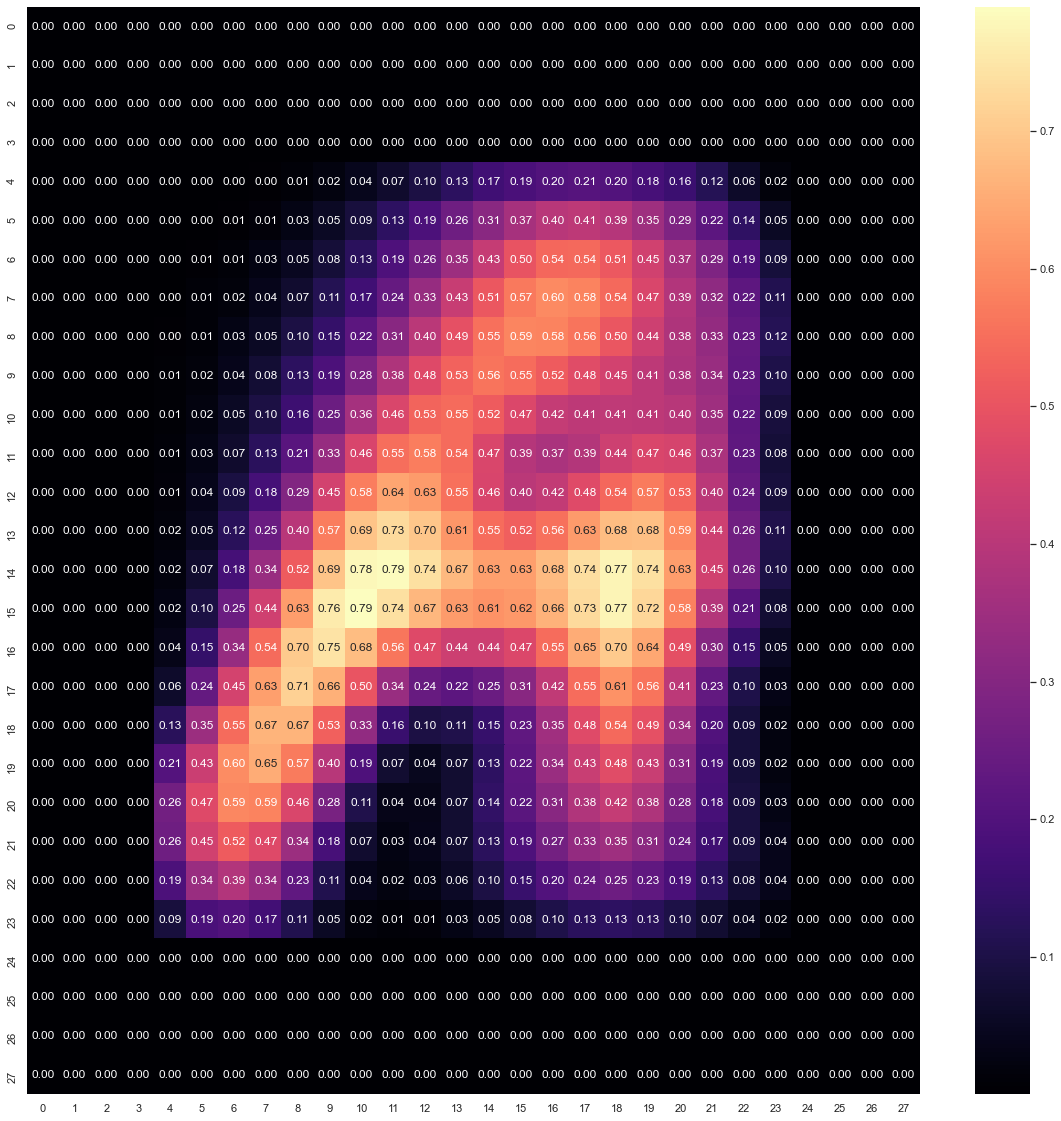

In [23]:
# lest see probabilities for any letter say A
letter =  0 # A

# we will plot the probabilities in a 2d grid as done above
# we will use a color map as well as show the numbers

probData = np.array(ourModel['conditional'][letter]).reshape(dim, dim)

# plot the heat map

sns.set(rc = {'figure.figsize':(20,20)} , font_scale = 1)
sns.heatmap(probData, cmap='magma', annot=True, fmt='.2f')

In [24]:
sns.set(rc = {'figure.figsize':(20,20)} , font_scale = 1.4)

In [25]:
import plotly.graph_objects as go

# lets plot a 3d plot of the probabilities 
fig = go.Figure(data=go.Surface(z=probData))
fig.update_layout(title='Probabilities for letter A', autosize=False, width=800, height=800)  
fig.show()


## Calulating probabilities using Bayes Theorem
As per Bayes Theorem:
\begin{equation}
P(Y = y | X = x) = \frac{P(X = x | Y = y)P(Y = y)} {\sum_{y=1}^{26}P(Y=y)  P(X = x | Y = y)}
\end{equation}

Applying Naiive Bayes Approximation the above equation can be chaged to:
\begin{equation}
P(Y = y | X = x) = \frac{\prod_{i=1}^{784}P(X_i = x_i | Y = y)P(Y = y)} {\sum_{y=1}^{26}\prod_{i=1}^{784}P(X_i = x_i | Y = y)P(Y = y)}
\end{equation}

Here we are interested in predicting the label so we will atlast to the argmax of the above equation i.e. the label with the highest probability.
\begin{equation}
y = argmax_{y=1}^{26}P(Y = y | X = x)
\end{equation}
And as we can see the denominator is same for each label, so we can just compute the numerator for each label and then find the label with the highest numerator.

### Log of the probabilities
We can also use log of the probabilities to avoid underflow. As we are again interested in the maximum and log is an monotonically increasing function, we can use log of the probabilities to avoid underflow.

We can take log and convert our formula to the following:
\begin{equation}
P(Y = y | X = x) = \log{\frac{P(X = x | Y = y)P(Y = y)}{\sum_{y=1}^{26}P(Y=y)  P(X = x | Y = y)}}
\end{equation}

We can  drop the denominator here as well so our equation will look like:
\begin{equation}
P(Y = y | X = x) = \log{\prod_{i=1}^{784}P(X_i = x_i | Y = y)P(Y = y)}
\end{equation}

We can use logarithmic property to convert the product into sum. So our equation will look like:
\begin{equation}
P(Y = y | X = x) = \sum_{i=1}^{784} \log{P(X_i = x_i | Y = y)} + \log{P(Y = y)}
\end{equation}

Note that they are not correct values for probability though we are using P, but this is enough to calculate the argmax.

Each function we have created to compute the probability for labels takes an argument to switch between log probability and non-log probability.


In [26]:
# lets create a probability calculator using the above equation
def calculateProb(x, model = ourModel, useLog = True):
    """
    Calculate the conditional probability for each label given a single feature (image)

    Params:
        x: a single image (numpy array)
        model: the model to use (dictionary)
        useLog: use log probabilities (boolean)
    Returns:
        a dictionary of probabilities
    """
    # get the prior probabilities
    prior = model['prior']
    # get the conditional probabilities
    conditional = model['conditional']
    
    result = np.zeros(26)
    for label in range(26):
        # get the conditional probability for the label
        condProb = conditional[label]
        # if the value for a particluar feature is 1 then we multiply the conditional probability
        # if the value for a particluar feature is 0 then we multiply the 1 - conditional probability 
        
        # condProbBased on the value of the feature
        condProbBasedOnFeature = np.array([condProb[i] if x[i] == 1 else (1 - condProb[i]) for i in range(x.shape[0])])
        if useLog:
            # if we are using log then we need to add the log of the conditional probability
            # and then add the log of the prior probability
            result[label] = np.log(prior[label]) + np.sum(np.log(condProbBasedOnFeature))
        else:
        # multiply the prior probability and the conditional probability
            result[label] = np.prod(condProbBasedOnFeature) * prior[label]
    return result
    

In [27]:
# function to calculat probability for a batch of features
def calculateProbBatch(X, model = ourModel, useLog = True):
    """
    Calculate the probability for each label given a batch of features (images)

    Params:
        X (numpy.array): A batch of features (images)
        model (dict): The model
    Returns:
        numpy.array: The probability for each label
    """

    ## This code works but is very slow so is commented out
    # nSamples = X.shape[0]
    # result = []
    # for i in range(nSamples):
    #     result.append(calculateProb(X[i], model))
    # return np.array(result)


    conditionalProb = model['conditional']
    prior = model['prior']
    probsForAllSample = []
    X = X.copy()        
    for label in range(26):
        # get the conditional probability for the label
        condProb = conditionalProb[label]
        pr = prior[label]
        # duplicate the conditional probability for all the samples
        condProbs = np.tile(condProb, (X.shape[0], 1))
        # multiply the conditional probability with the features
        zerosPlaces = X.copy()
        zerosPlaces = 1 - zerosPlaces # make 1 where x is 0 else make it 0
        # check if Z and zeroPlaces are complements
        assert np.all(np.logical_xor(X, zerosPlaces))
        probWithOnes = np.multiply(condProbs , X ) # keep only probs where x is 1
        probWithZeros = np.multiply(condProbs,  zerosPlaces) # keep only probs where x is 0
        probWithZeros = zerosPlaces - probWithZeros # make 1 - probs where x is 0 else make it 0
        allProbs = probWithOnes + probWithZeros # make 1 - probs where x is 0 else make it probs
        
        if useLog:
            totalProbability = np.sum(np.log(allProbs), axis = 1)
            totalProbability = totalProbability + np.log(pr)
        else:
            # calculate the product of all probabilites as well as prior
            totalProbability = np.prod(allProbs, axis=1) * pr 
            # append the result to the list
        probsForAllSample.append(totalProbability)
    probsForAllSample = np.array(probsForAllSample).T
    return probsForAllSample


In [28]:
def predict(x, model = ourModel, useLog = True):
    """
    Predict the label for a single feature (image)
    Params:
        x (numpy.array): A single feature (image)
        model (dict): The model
    Returns:
        int: The predicted label
    """
    # Get the class probabilities of the image x
    prob = calculateProb(x, model, useLog)
    # Get the index of the maximum value in the class/label probabilities
    return np.argmax(prob)

In [29]:
def predictBatch(X, model = ourModel, useLog = True):
    """
    Predict the label for a batch of features (images)

    Params:
        X (numpy.array): A batch of features (images)
        model (dict): The model
    Returns:
        numpy.array: The predicted labels
    """
    # Get the probabilities of the images in X
    prob = calculateProbBatch(X, model, useLog)
    # Get the index of the maximum value in the class probabilities
    return np.argmax(prob, axis=1)

Now before calculating accuracies etc lets predict few examples from the test set as we did for previous section.

(74490, 784) (74490,)


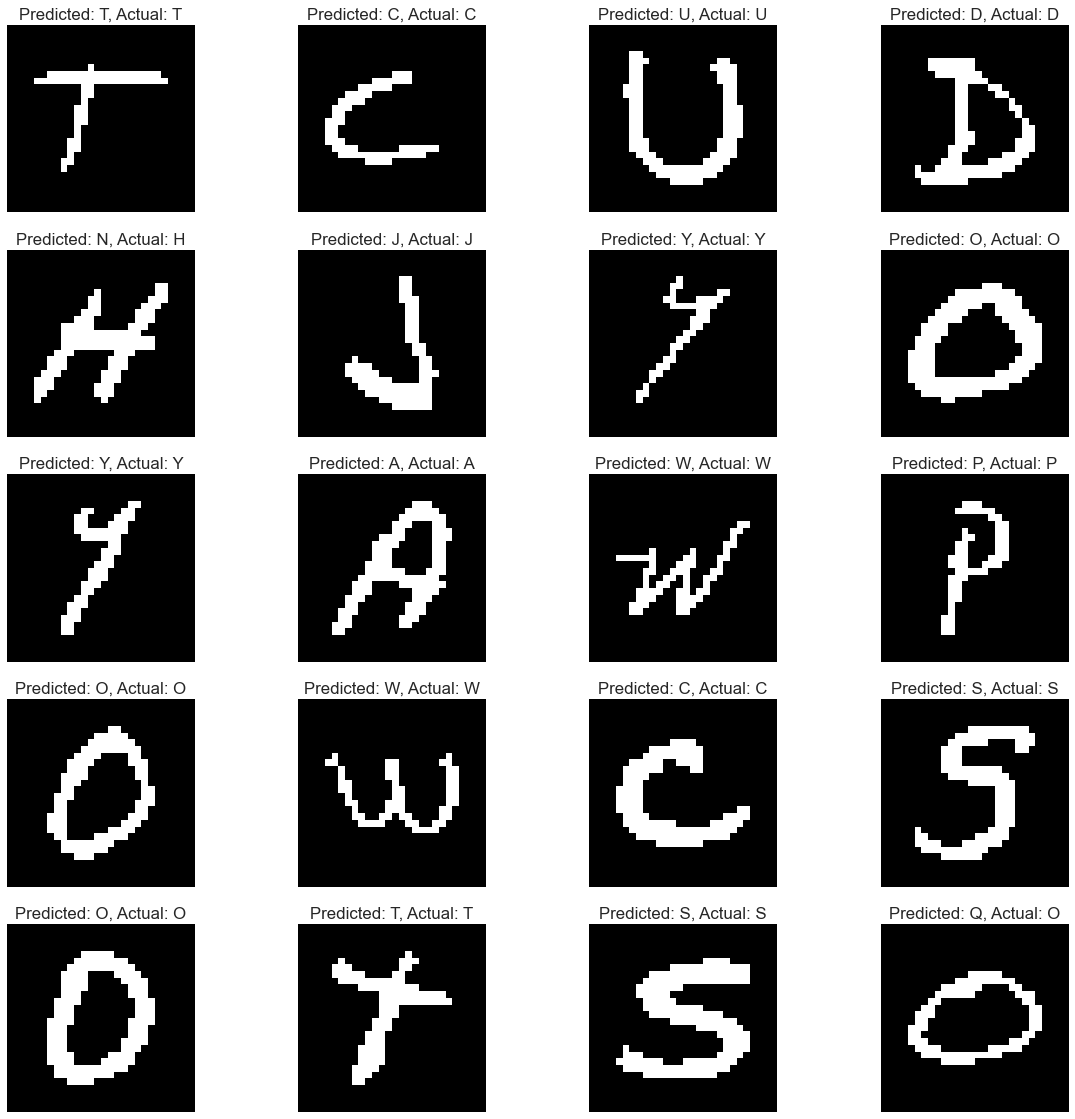

In [30]:
# select few radom images from the test data
testFeatures = test[pixelsNumbers]
testLabels = test['label']
print(testFeatures.shape, testLabels.shape)
figure = plt.figure(figsize=(20, 20))
for i in range(20):
    index = np.random.randint(0, testFeatures.shape[0])
    x = testFeatures.iloc[index]
    y = testLabels.iloc[index]
    y_pred = predict(x, useLog = True)
    # plot the image as a gray scale image sub plot
    plt.subplot(5, 4, i + 1)
    plt.imshow(x.values.reshape(dim, dim), cmap='gray')
    plt.axis('off')
    # plot the predicted label and actual label
    plt.title('Predicted: {}, Actual: {}'.format(chr(y_pred + 65), chr(y + 65)))
plt.tight_layout
plt.show()

### Now calculate error metrics for whole test set using our model
We will use similar logic as in previous section to calculate the error metrics for the whole test set. 

In [31]:
# might take long time to run, around 10 15 minutes
testPredictions = predictBatch(testFeatures.values)

In [32]:
accuracy = np.mean(testPredictions == testLabels)
error = 1 - accuracy

In [33]:
# printing accuracuies and error
print('Accuracy: {}'.format(accuracy))
print('Error: {}'.format(error))

Accuracy: 0.6941065914887904
Error: 0.3058934085112096


### Now calculate error and accuracies for each label
As data was little skewed and due to some other reasons as well lets first check the accuracy of the model for each label.

In [34]:
# might take long time to run, around 10 15 minutes
testBylabel = test.groupby('label')
accuracyPerLabel = []
 
# calculate the accuracy for each label
for label in range(26):
    # get the test data for the label
    Data = testBylabel.get_group(label)
    # get the features for the label
    Features = Data[pixelsNumbers]
    # get the labels for the label
    Labels = Data['label']
    # get the predictions for the label
    Predictions = predictBatch(Features.values)
    # calculate the accuracy for the label
    accuracy = np.mean(Predictions == Labels)
    # append the accuracy to the list
    accuracyPerLabel.append(accuracy)

In [35]:
for label in range(26):
    print('Accuracy for label {}: {}'.format(chr(label + 65), accuracyPerLabel[label]))

Accuracy for label A: 0.72831541218638
Accuracy for label B: 0.7367491166077739
Accuracy for label C: 0.7140039447731755
Accuracy for label D: 0.7086059386009059
Accuracy for label E: 0.6010544815465729
Accuracy for label F: 0.8884297520661157
Accuracy for label G: 0.7333333333333333
Accuracy for label H: 0.5609756097560976
Accuracy for label I: 0.8761467889908257
Accuracy for label J: 0.5984669811320755
Accuracy for label K: 0.6810810810810811
Accuracy for label L: 0.7240356083086054
Accuracy for label M: 0.8844911147011308
Accuracy for label N: 0.6158488585673052
Accuracy for label O: 0.7615424520145253
Accuracy for label P: 0.737516339869281
Accuracy for label Q: 0.6861564918314703
Accuracy for label R: 0.5018773466833542
Accuracy for label S: 0.6652736724085211
Accuracy for label T: 0.6920446774561203
Accuracy for label U: 0.6172669308978115
Accuracy for label V: 0.8525
Accuracy for label W: 0.7798594847775175
Accuracy for label X: 0.6640316205533597
Accuracy for label Y: 0.7065654

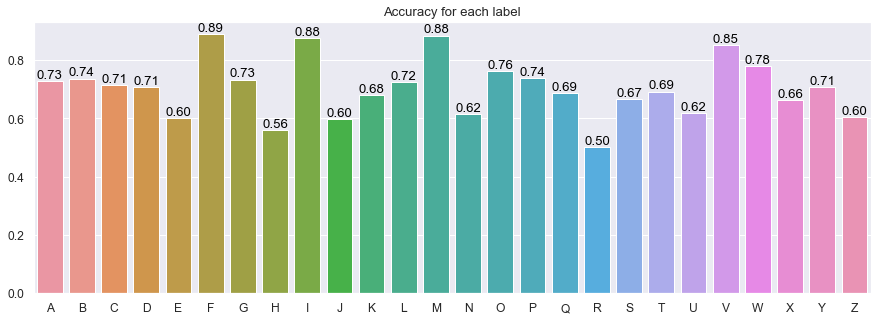

In [36]:
# lets plot the accuracies for each label
sns.set(rc = {'figure.figsize':(15,5)} , font_scale = 1.1)
sns.barplot(x=[chr(i+65) for i in range(26)], y=accuracyPerLabel)
plt.title('Accuracy for each label')
# write values over the bars
for i, v in enumerate(accuracyPerLabel):
    plt.text(i, v, '{:.2f}'.format(v), color='black', ha='center', va='bottom')
plt.show()

### Confusion Matrix
Confusion matrix is a table that shows the number of correct and incorrect predictions made by the model. They gave us better understanding of the performance of the model.


In [37]:
# creating a confusion matrix
def createConfusionMatrix(model = ourModel, testPredictions = testPredictions, testLabels = testLabels.values):
    """
    This function creates a confusion matrix for the model.

    Params:
        model (dict): The model
        testPredictions (numpy.array): The predictions
        testLabels (numpy.array): The labels
    Returns:
        numpy.array: The confusion matrix
    """
    # create an empty matrix
    confusionMatrix = np.zeros((26, 26))
    # iterate over the predictions and labels
    for i in range(len(testPredictions)):
        # get the predicted label
        predictedLabel = testPredictions[i]
        # get the actual label
        actualLabel = testLabels[i]
        # increment the confusion matrix
        confusionMatrix[predictedLabel][actualLabel] += 1
    return confusionMatrix

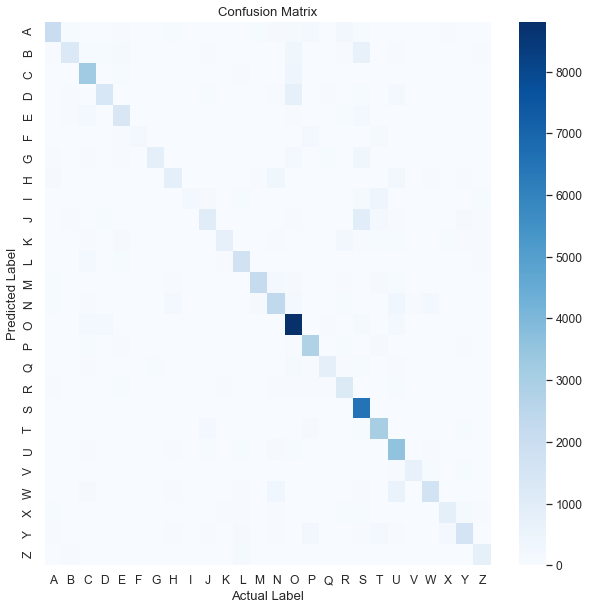

In [38]:
confusionMatrix  = createConfusionMatrix()
# plot the confusion matrix as a heat map
plt.figure(figsize=(10, 10))
sns.heatmap(confusionMatrix, cmap='Blues', xticklabels=[chr(i+65) for i in range(26)], yticklabels=[chr(i+65) for i in range(26)])
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

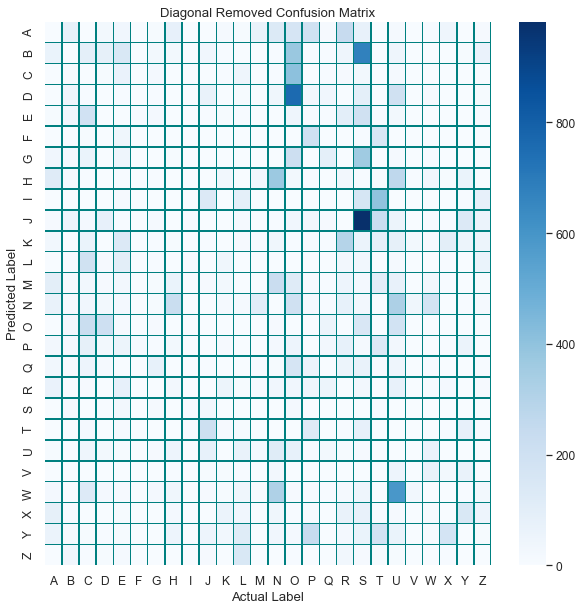

In [39]:
# plot the confusion matrix as a heat map by ignoring the diagonal
# this will make other values more prominent and visible
diagonalRemovedConfusionMatrix = np.zeros((26, 26))
for i in range(26):
    for j in range(26):
        if i != j:
            diagonalRemovedConfusionMatrix[i][j] = confusionMatrix[i][j]
        

plt.figure(figsize=(10, 10))
sns.heatmap(diagonalRemovedConfusionMatrix, cmap='Blues', xticklabels=[chr(i+65) for i in range(26)], yticklabels=[chr(i+65) for i in range(26)], linecolor='teal',linewidths=0.5)
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.title('Diagonal Removed Confusion Matrix')

# show boundaries
plt.show()

We can use the above matrix to see which letters are more wrongly predicted as which other letter. As here we can see S is wrongly predicted as J lots of times etc.

### Classification Report
https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397

classification report is a table that shows the precision, recall, f1-score and support for each class. This is more useful when we have more than two classes and the distribution of the classes is not balanced.

We can calulate classification report for confusion matrix.

For a binary class precision is the fraction of correct predictions made by the model with total . It is calculated as: 
\begin{equation}
Precision = \frac{TP}{TP+FP}
\end{equation}

Similarly Recall is calculated as:
\begin{equation}
Recall = \frac{TP}{TP+FN}
\end{equation}

F1 score is calculated as:
\begin{equation}
F1 score = 2\frac{Precision * Recall}{Precision+Recall}
\end{equation}

We  can extend this to more than two classes as well.

In [40]:
# calculating classification report for the confusion matrix for each label
def calculateClassificationReport(confusionMatrix = confusionMatrix):
    """
    This function calculates the classification report for the confusion matrix.

    Params:
        confusionMatrix (numpy.array): The confusion matrix
    Returns:
        dict: The classification report
    """
    # create an empty list
    result = []
    # iterate over the confusion matrix
    for label in range(26):
        # caculating precision
        precision = confusionMatrix[label][label] / np.sum(confusionMatrix[label])
        # caculating recall
        recall = confusionMatrix[label][label] / np.sum(confusionMatrix[:, label])
        # caculating f1 score
        f1Score = 2 * (precision * recall) / (precision + recall)
        result.append([chr(label + 65), precision, recall, f1Score])
    return result


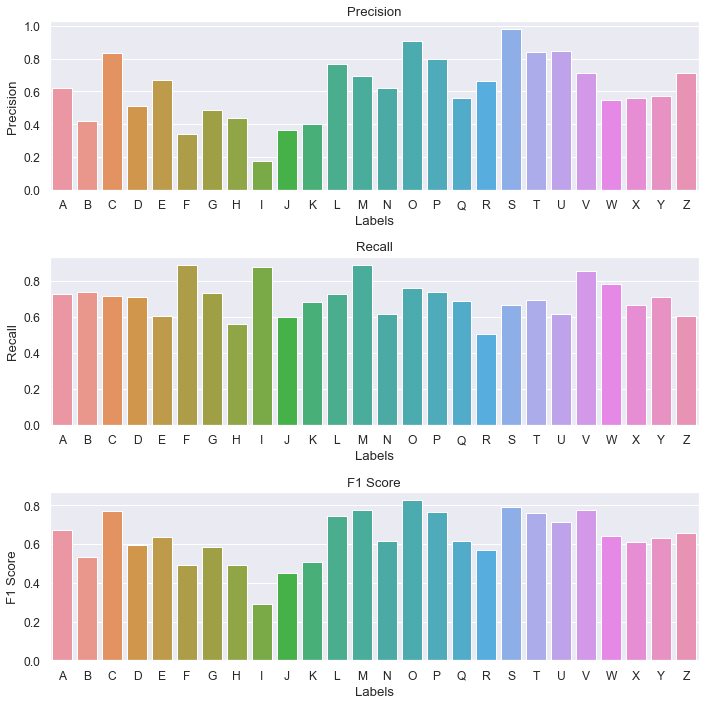

In [41]:
classificationReport = calculateClassificationReport()

# plot the classification precision recall and f1 barplots for each label in single plot as subplots
figure = plt.figure(figsize=(10, 10))
# plot precision subplot
plt.subplot(3, 1, 1)
sns.barplot(x=[chr(i+65) for i in range(26)], y=[row[1] for row in classificationReport])
plt.xlabel('Labels')
plt.ylabel('Precision')
plt.title('Precision')
# plot recall subplot
plt.subplot(3, 1, 2)
sns.barplot(x=[chr(i+65) for i in range(26)], y=[row[2] for row in classificationReport])
plt.xlabel('Labels')
plt.ylabel('Recall')
plt.title('Recall')
# plot f1 score subplot
plt.subplot(3, 1, 3)
sns.barplot(x=[chr(i+65) for i in range(26)], y=[row[3] for row in classificationReport])
plt.xlabel('Labels')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.tight_layout()
plt.show()

## Improving the accuracy of the model
Accuracy machine learning model can be improved in various ways, like by using more data or by using more features. If more data is not availble we can use other methods like data augmentation.

We can also tune the hyperparameters of the model to improve the accuracies. 

### Tuning the hyperparameters
If we fix the model then we are left here with only one hyperparameter to tune, which is the threshold value we used to convert the pixels to black or white. We took it as 50% by default but we try to tune it to see if we can improve the accuracies.

In [42]:
# creating a dataframe for images using different threshold values
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
df = df_copy.copy()

In [43]:
def transformData(df, threshold, maxVal = 255):
    newDf = df.copy()
    threshold = threshold * maxVal
    newDf[pixelsNumbers] = newDf[pixelsNumbers].apply(lambda x: (x > threshold).astype(int))
    return newDf

In [44]:
dfList = []
for threshold in thresholds:
    dfList.append(transformData(df, threshold))

In [45]:
print(len(dfList))
print(dfList[0].shape)

9
(372450, 785)


Lets see some images from each threshold value.

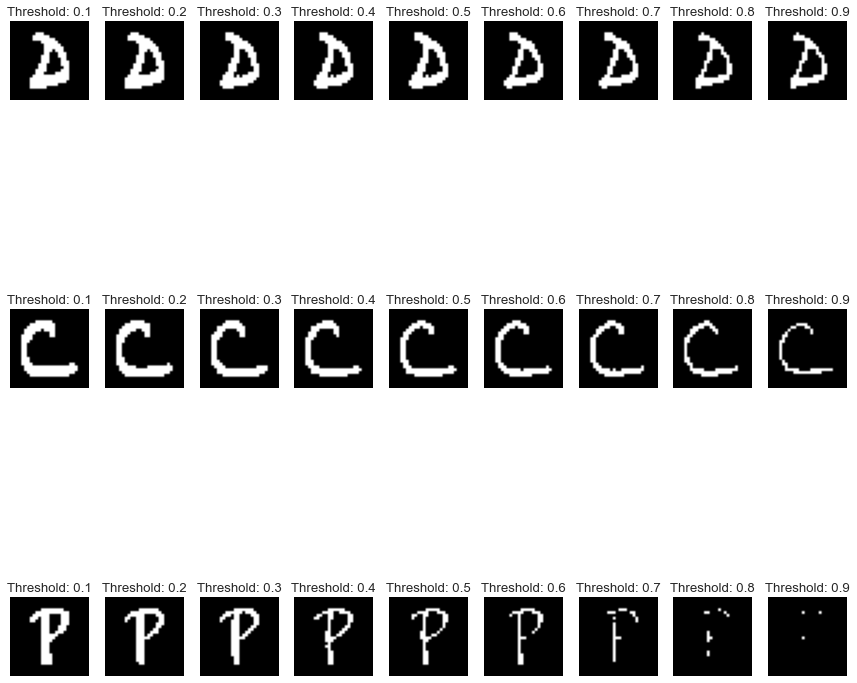

In [46]:
# select some random index
# select 3 random images
rind = np.random.randint(0, dfList[0].shape[0], 3)

# plot the images for each threshold
figure , axis = plt.subplots(3, 9, figsize=(15, 15))
for th in range(len(thresholds)):
    curDf = dfList[th]
    for i in range(3):
        axis[i][th].imshow(curDf.iloc[rind[i]][pixelsNumbers].values.reshape(28, 28), cmap='gray')
        axis[i][th].set_title('Threshold: {}'.format(thresholds[th]))
        axis[i][th].axis('off')

Now lets create train and score model with different threshold values and compare their accuracies.

In [47]:
# can take longf time to run around 10 minutes
scores = []
itr = 0
for df in dfList:
    print('Calculating accuracy for threshold: {}'.format(thresholds[itr]))
    itr+=1
    # partision the data into train and test
    train, test = train_test_split(df, test_size=0.2)
    # get the features for the train data
    X_train = train[pixelsNumbers]
    # get the labels for the train data
    y_train = train['label']
    # get the features for the test data
    X_test = test[pixelsNumbers]
    # get the labels for the test data
    y_test = test['label']

    # create a model
    m = nb.CategoricalNB(fit_prior=True, min_categories=2)
    # fit the model
    m.fit(X_train, y_train)
    # score the model
    score = m.score(X_test, y_test)
    scores.append(score)

Calculating accuracy for threshold: 0.1
Calculating accuracy for threshold: 0.2
Calculating accuracy for threshold: 0.3
Calculating accuracy for threshold: 0.4
Calculating accuracy for threshold: 0.5
Calculating accuracy for threshold: 0.6
Calculating accuracy for threshold: 0.7
Calculating accuracy for threshold: 0.8
Calculating accuracy for threshold: 0.9


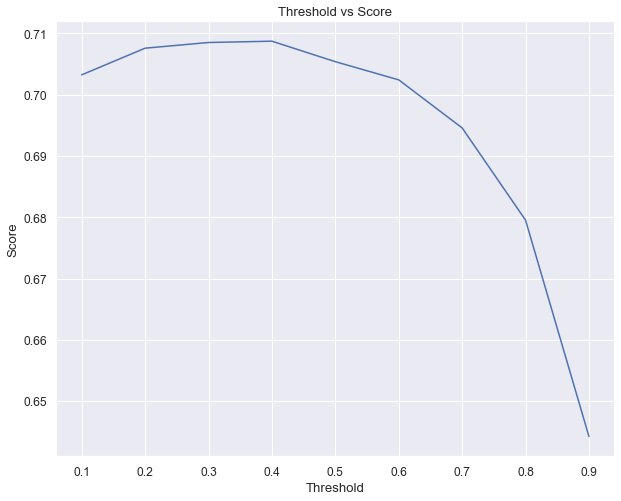

Best Threshold: 0.4, Score : 0.7087260034904014


In [48]:
# visializing the scores for different threshold values
plt.figure(figsize=(10, 8))
plt.plot(thresholds, scores)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Score')
plt.show()

# mark the best threshold value
bestThreshold = thresholds[np.argmax(scores)]
print('Best Threshold: {}, Score : {}'.format(bestThreshold, np.max(scores)))

### More possible values for features
Till now we have used a binary values for features, but we can also use more than two values. For example, we can use a 3-value feature for each pixel. We can say that from 0 to 33% of the pixel is 0 i.e. complete black, 33% to 66% is grayish i.e 1 and 66% to 100% is white i.e. 2.

Also this selection of equal distribution of values is also a hyperparameter but we wont consider it here.

Lets first partision the data base on this principle.


In [55]:
df = df_copy.copy()

# discretise the data 0 for < 33% 1 for < 66% and 2 for rest
p1 = 255 * 0.33
p2 = 255 * 0.66
df[pixelsNumbers] = df[pixelsNumbers].apply(lambda x : (x > p1).astype(int) + (x > p2).astype(int))
df.head()



,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# partision the data into train and test
train, test = train_test_split(df, test_size=0.2)

In [57]:
# create the model
m = nb.CategoricalNB(fit_prior=True, min_categories=3)

# fit the model
m.fit(train[pixelsNumbers], train['label'])

CategoricalNB(min_categories=3)

In [58]:
# score the model
score = m.score(test[pixelsNumbers], test['label'])
print('Score: {}'.format(score))


Score: 0.7105786011545174


As we can see accuracy did increase by a bit, now just out of curiousity lets try more possible values for features. Lets say 10 possible values for each pixel.

In [64]:
df = df_copy.copy()
ps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# discretise the data from 0 to 9
df[pixelsNumbers] = df[pixelsNumbers].apply(lambda x : (x > 255 * 0.1).astype(int) + (x > 255 * 0.2).astype(int) + (x > 255 * 0.3).astype(int) + (x > 255 * 0.4).astype(int) + (x > 255 * 0.5).astype(int) + (x > 255 * 0.6).astype(int) + (x > 255 * 0.7).astype(int) + (x > 255 * 0.8).astype(int) + (x > 255 * 0.9).astype(int))
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
# create the model
m = nb.CategoricalNB(fit_prior=True, min_categories=10)

# partision the data into train and test
train, test = train_test_split(df, test_size=0.2)

# fit the model
m.fit(train[pixelsNumbers], train['label'])


CategoricalNB(min_categories=10)

In [67]:
# score the model
score = m.score(test[pixelsNumbers], test['label'])
print('Score: {}'.format(score))

Score: 0.7155994093166868
